In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
from  tqdm import tqdm
import os
import torch.optim as optim
import idx2numpy


images_root_folder = "images-fashion-MLP-VAE"

if not os.path.exists(f"{images_root_folder}"):
    os.mkdir(f"{images_root_folder}")


# Load the labels file
trainPath = "fashion-MNIST/train-images-idx3-ubyte"
testPath = "fashion-MNIST/t10k-images-idx3-ubyte"

train = idx2numpy.convert_from_file(trainPath)
test = idx2numpy.convert_from_file(testPath)
train=torch.Tensor(train)
test=torch.Tensor(test)
train=torch.flatten(train,start_dim=1)
test=torch.flatten(test,start_dim=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH="MLP-VAE-Fashion_MNIST-Dataset-Model"
EPOCHS=50
lr=0.0001
latent_dim=64
beta = 4

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VariationalEnc(nn.Module):
    def __init__(self,x):
        super(VariationalEnc, self).__init__()
        self.l1=nn.Linear(784,512)
        self.l2=nn.Linear(512,x)
        self.l3=nn.Linear(512,x)
        self.dis=torch.distributions.Normal(0, 1)
        self.dis.loc = self.dis.loc.cuda() # hack to get sampling on the GPU
        self.dis.scale = self.dis.scale.cuda()
        self.kld=0
    def forward(self,x):
        x=self.l1(x)
        x = F.relu(x)
        mu=self.l2(x)
        sig=torch.exp(self.l3(x))
        z=mu + sig*self.dis.sample(mu.shape)
        self.kld=(sig**2 + mu**2 - torch.log(sig) - 1/2).sum()
        return z


class Decoder(nn.Module):
    def __init__(self,x):
        super(Decoder, self).__init__()
        self.l1=nn.Linear(x,512)
        self.l2=nn.Linear(512,784)

    def forward(self,x):
        ans=self.l1(x)
        ans=F.relu(ans)
        ans=self.l2(ans)
        ans = torch.sigmoid(ans)
        return ans



class VAE(nn.Module):
    def __init__(self,x):
        super(VAE, self).__init__()
        self.enc=VariationalEnc(x)
        self.dec=Decoder(x)

    def forward(self,x):
        x=self.enc(x)
        return self.dec(x)


def chaap2(orignal,decoded, idx, epo):
    if not os.path.exists(f"{images_root_folder}/{epo}"):
        os.mkdir(f"{images_root_folder}/{epo}")

    org1=torch.tensor(orignal)
    org1=org1.detach().cpu().numpy()
    org1=np.resize(org1,(28,28))

    dec1=torch.tensor(decoded)
    dec1=dec1.detach().cpu().numpy()
    dec1=np.resize(dec1,(28,28))

    output_path = f"{images_root_folder}/{epo}/{idx}"
    if not os.path.exists(f"{output_path}"):
        os.mkdir(f"{output_path}")

    plt.imsave(f"{output_path}/original.png" , org1, cmap='gray')
    plt.imsave(f"{output_path}/decoded.png" , dec1, cmap='gray')

In [7]:

vaenc=VAE(latent_dim).to(device)
opt = torch.optim.Adam(vaenc.parameters())

for i in range(EPOCHS):
    for idx,x in enumerate(tqdm(train)):
        opt.zero_grad()
        x=x/255
        x=x.to(torch.float32)
        x = x.to(device) # GPU
        xx=vaenc.forward(x)
#         print(xx)

        if(idx % 1000 == 0 or idx == train.shape[0]-1):
            chaap2(x,xx, idx, i)

#         print(x)

        #losses=torch.linalg.norm(xx-x,2)/784 + vaenc.enc.kld
        losses = ((x - xx)**2).sum() + beta*vaenc.enc.kld


        losses.backward()
        opt.step()


torch.save(vaenc.state_dict(), PATH)




  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]C:\Users\Vaibhav Tanwar\AppData\Local\Temp\ipykernel_26976\733239393.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  org1=torch.tensor(orignal)
C:\Users\Vaibhav Tanwar\AppData\Local\Temp\ipykernel_26976\733239393.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dec1=torch.tensor(decoded)
100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:34<00:00, 218.75it/s]


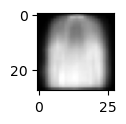

In [45]:
required = torch.randn(64);
plt.figure(figsize=(1,1))

plt.imshow(vaenc.dec(required.to(device)).detach().cpu().numpy().reshape(28,28),cmap='gray')

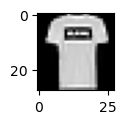

In [47]:
plt.figure(figsize=(1,1))
plt.imshow(train[1].reshape(28,28),cmap='gray')